In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

<div class="alert alert-block alert-info">

**stage_to_project**:
- stagedproject_id — id этапа; <br> 
- project_id — id проекта. <br>

**hours_to_projects**:
- day — дата, на которую запланирован специалист; <br>
- project_id — id этапа или проекта; * <br>
- executive_id — id специалиста, который был запланирован; <br>
- hours — кол-во часов; <br>
- dt — datetime заявки. <br>

\**Если id есть в поле stage_to_project.stagedroject_id, значит это id этапа, который является частью проекта. <br>
   Если id в поле stage_to_project.stagedroject_id не встречается, значит этот проект имеет только один этап, <br>
   потому сразу указан id проекта.* <br>

**executive_to_spec**:
- executive_id — id специалиста; <br>
- spec — его специальность.
</div>

In [3]:
df_executive_to_spec = pd.read_csv('executive_to_spec.csv')
df_hours_to_project = pd.read_csv('hours_to_project.csv')
df_stage_to_project = pd.read_csv('stage_to_project.csv')

<div class="alert alert-success">
<h3> 1. Почистить данные. <br>
Специалист не может быть запланирован более чем на 8 часов в день. <br>
Все, что более 8 часов, должно быть срезано. <br>
Срезать нужно по принципу: кто раньше успел запланировать специалиста, тот и прав. <br>
Время планирования указано в колонке dt.</h3>
</div>

Удалим строки с нулевым значением количества запланированных часов и отсортируем по времени заявки:

In [4]:
df_hours_to_project = df_hours_to_project.query("hours != 0").sort_values(['dt'])

Добавим накопительную сумму часов в разрезе дня и исполнителя:

In [5]:
df_hours_to_project['hours_cumsum'] = df_hours_to_project.groupby(['day', 'executive_id'])['hours'].cumsum()

Посмотрим на примере одного исполнителя и пары дней. <br>
В строке 1491 в итоге должно остаться 3 часа, т.к. максимум 8 часов в день. <br>
А строки 2033 и 2034 должны быть отброшены:

In [6]:
df_hours_to_project.query("executive_id == 5998389653881847132 and day == ['2019-01-14', '2019-01-15']").sort_values(['day'])

,day,project_id,executive_id,hours,dt,hours_cumsum
1297,2019-01-14,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16,3
1313,2019-01-14,3016404,5998389653881847132,1,2018-12-26 15:45:22,4
1273,2019-01-14,4444406835586699375,5998389653881847132,1,2018-12-26 16:28:18,5
1491,2019-01-14,3017043,5998389653881847132,4,2018-12-26 16:28:40,9
2033,2019-01-14,4444406853899056045,5998389653881847132,1,2019-01-09 14:37:21,10
1298,2019-01-15,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16,3
1314,2019-01-15,3016404,5998389653881847132,1,2018-12-26 15:45:22,4
1492,2019-01-15,3017043,5998389653881847132,4,2018-12-26 16:28:40,8
2034,2019-01-15,4444406853899056045,5998389653881847132,1,2019-01-09 14:37:21,9


Сформируем новый столбец с часами **'hours_cleared'**.  
Если накопленное время меньше либо равно 8-ми часам - оставляем количество часов как текущее значение **hours**,  
иначе уменьшаем **hours** на количество превышения нормы **(hours_cumsum - 8)**.

In [7]:
def get_cleared_hours(row):
    if row.hours_cumsum <= 8:
        return row.hours
    return row.hours - (row.hours_cumsum - 8)

In [8]:
df_hours_to_project['hours_cleared'] = df_hours_to_project.apply(get_cleared_hours, axis=1)

Проверим наш пример:

In [9]:
df_hours_to_project.query("executive_id == 5998389653881847132 and day == ['2019-01-14', '2019-01-15']").sort_values(['day'])

,day,project_id,executive_id,hours,dt,hours_cumsum,hours_cleared
1297,2019-01-14,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16,3,3
1313,2019-01-14,3016404,5998389653881847132,1,2018-12-26 15:45:22,4,1
1273,2019-01-14,4444406835586699375,5998389653881847132,1,2018-12-26 16:28:18,5,1
1491,2019-01-14,3017043,5998389653881847132,4,2018-12-26 16:28:40,9,3
2033,2019-01-14,4444406853899056045,5998389653881847132,1,2019-01-09 14:37:21,10,-1
1298,2019-01-15,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16,3,3
1314,2019-01-15,3016404,5998389653881847132,1,2018-12-26 15:45:22,4,1
1492,2019-01-15,3017043,5998389653881847132,4,2018-12-26 16:28:40,8,4
2034,2019-01-15,4444406853899056045,5998389653881847132,1,2019-01-09 14:37:21,9,0


Все верно. Далее просто уберем строки с нулевыми и отрицательными значениями **'hours_cleared'** и сформируем итоговый датафрейм:

In [10]:
df_hours_to_project = (df_hours_to_project.query("hours_cleared > 0")
                       [['day', 'project_id', 'executive_id', 'hours_cleared', 'dt']].reset_index(drop = True))

In [11]:
df_hours_to_project.query("executive_id == 5998389653881847132 and day == ['2019-01-14', '2019-01-15']").sort_values(['day'])

,day,project_id,executive_id,hours_cleared,dt
692,2019-01-14,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16
710,2019-01-14,3016404,5998389653881847132,1,2018-12-26 15:45:22
927,2019-01-14,4444406835586699375,5998389653881847132,1,2018-12-26 16:28:18
936,2019-01-14,3017043,5998389653881847132,3,2018-12-26 16:28:40
693,2019-01-15,5852176997052179571,5998389653881847132,3,2018-12-26 15:45:16
706,2019-01-15,3016404,5998389653881847132,1,2018-12-26 15:45:22
937,2019-01-15,3017043,5998389653881847132,4,2018-12-26 16:28:40


<div class="alert alert-success">
<h3>2. Найти 20 наименее занятых специалистов (на уровне id) за март.</h3>
</div>

In [12]:
(df_hours_to_project.query("'2019-03-01' <= day <= '2019-03-31'")
                    .groupby(['executive_id'])['hours_cleared'].sum().sort_values()
                    .head(20).to_frame(name='march_hours_sum').reset_index())

,executive_id,march_hours_sum
0,4769141486593889576,4
1,6533079396805353174,5
2,6513879110580805865,7
3,6665533916176314412,20
4,6080792866358144384,22
5,6470047208388519868,26
6,6573593990812262863,37
7,6668223824129031472,40
8,4638737517754019940,42
9,6497176700026191849,42


<div class="alert alert-success">
<h3> 3. Построить распределение длительностей проектов.</h3>
</div>

Объединим два датафрейма **df_hours_to_project** и **df_stage_to_project**, оставив только необходимые столбцы:

In [13]:
projects_durations = (df_hours_to_project[['day', 'project_id']]
                     .merge(df_stage_to_project, how='left', left_on='project_id', right_on='stagedproject_id'))

In [14]:
projects_durations.head(10)

,day,project_id_x,stagedproject_id,project_id_y
0,2019-01-17,3016817,3016817.0,6.612947e+18
1,2019-01-16,3016817,3016817.0,6.612947e+18
2,2019-01-15,3016817,3016817.0,6.612947e+18
3,2019-01-14,3016817,3016817.0,6.612947e+18
4,2019-01-18,3016817,3016817.0,6.612947e+18
5,2019-01-28,3016817,3016817.0,6.612947e+18
6,2019-01-29,3016817,3016817.0,6.612947e+18
7,2019-01-09,4444406876895586307,NaN,NaN
8,2019-01-11,4444406876895586307,NaN,NaN
9,2019-01-14,4444406876895586307,NaN,NaN


Заполним пропуски в **project_id_y** значениями из столбца **project_id_x** и преобразуем формат даты:

In [15]:
projects_durations['project_id_y'] = projects_durations['project_id_y'].fillna(projects_durations['project_id_x'])

In [16]:
projects_durations['day'] = pd.to_datetime(projects_durations['day'])

Сформируем итоговый датафрейм, вычислив продолжительность проектов:

In [17]:
projects_durations = (projects_durations[['day', 'project_id_y']].groupby('project_id_y')
                     .day.agg([lambda x: max(x) - min(x) + pd.Timedelta(1, unit="d")])
                     .reset_index()).rename(columns={'<lambda>': 'duration', 'project_id_y': 'project_id_'})

In [18]:
projects_durations.head(10)

,project_id_,duration
0,3.017137e+06,164 days
1,3.017138e+06,179 days
2,3.017139e+06,8 days
3,3.018203e+06,61 days
4,3.018249e+06,1 days
5,3.018554e+06,4 days
6,3.018612e+06,18 days
7,3.018903e+06,29 days
8,3.018952e+06,5 days
9,4.242424e+17,110 days


Построим гистограмму распределения длительностей проектов:

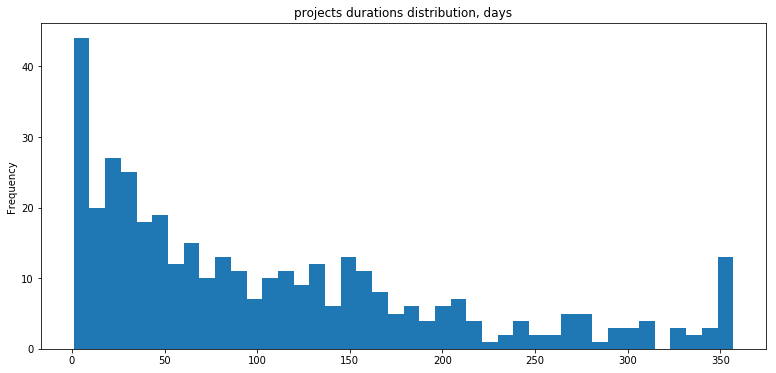

In [19]:
projects_durations.duration.dt.days.plot(kind='hist', 
                                         title='projects durations distribution, days',
                                         bins=42)

Видно, что у непродолжительных проектов в несколько дней частота самая высокая.  
Пик в самом конце графика видимо связан с группой длительных проектов переходящих из года в год.

Построим также диаграмму размаха (box plot) для длительностей проектов:

Text(0.5, 1.0, 'projects durations distribution, days')

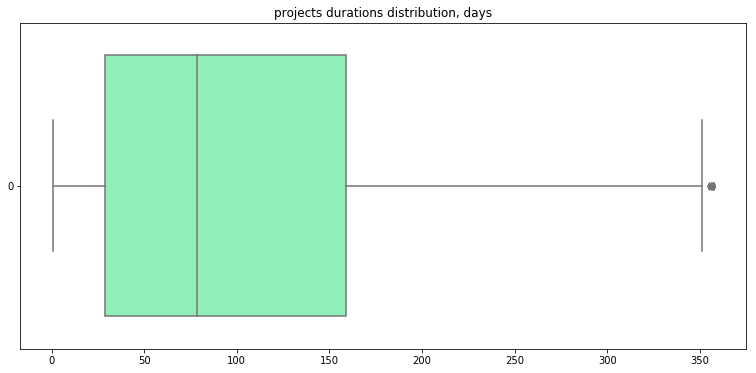

In [20]:
sns.boxplot(data=projects_durations.duration.dt.days, palette='rainbow', orient='h')
plt.title('projects durations distribution, days')

Половина всех проектоа имеет продолжительность от 1 до 5 месяцев.  
Медианная продолжительность 78 дней.

In [21]:
projects_durations.duration.describe()

count                         386
mean     107 days 19:50:03.108808
std       98 days 01:20:11.397475
min               1 days 00:00:00
25%              29 days 00:00:00
50%              78 days 12:00:00
75%             158 days 18:00:00
max             357 days 00:00:00
Name: duration, dtype: object

<div class="alert alert-success">
<h3> 4. Построить график занятости по специалистам от максимально возможного в течение года: <br>
    
— дизайнеров; <br>
— технологов; <br>
— всех сотрудников.</h3>
</div>

Объединим два необходимых датафрейма **df_hours_to_project** и **df_executive_to_spec**:

In [22]:
spec_days = (df_hours_to_project[['day', 'executive_id', 'hours_cleared']]
               .merge(df_executive_to_spec, how='left'))

In [23]:
spec_days.head()

,day,executive_id,hours_cleared,spec
0,2019-01-17,5625394194018276490,3,верстальщик
1,2019-01-16,5625394194018276490,3,верстальщик
2,2019-01-15,5625394194018276490,3,верстальщик
3,2019-01-14,5625394194018276490,3,верстальщик
4,2019-01-18,5625394194018276490,3,верстальщик


Сгруппируем по дате и специальности, аггрегировав сумму часов и количество уникальных id специалистов:

In [24]:
spec_workload = (spec_days.groupby(['day', 'spec'])
                              .agg({"hours_cleared": "sum", "executive_id": "nunique"}).reset_index())

Посмотрим на один день:

In [25]:
spec_workload.query("day == '2019-01-09'").head()

,day,spec,hours_cleared,executive_id
1,2019-01-09,архитектор,16,2
2,2019-01-09,бета-тестер,4,1
3,2019-01-09,верстальщик,22,5
4,2019-01-09,главный архитектор,4,1
5,2019-01-09,дизайнер,241,37


Добавим столбец **'workload'**, вычислив отношение количества часов к максимально возможному:

In [26]:
spec_workload['workload'] = spec_workload['hours_cleared'] / (spec_workload['executive_id'] * 8)

In [27]:
spec_workload.query("day == '2019-01-09'").head()

,day,spec,hours_cleared,executive_id,workload
1,2019-01-09,архитектор,16,2,1.000000
2,2019-01-09,бета-тестер,4,1,0.500000
3,2019-01-09,верстальщик,22,5,0.550000
4,2019-01-09,главный архитектор,4,1,0.500000
5,2019-01-09,дизайнер,241,37,0.814189


И посчитаем то же самое для всех сотрудников в целом:

In [28]:
all_workload = spec_days.groupby(['day']).agg({"hours_cleared": "sum", "executive_id": "nunique"}).reset_index()

In [29]:
all_workload.head()

,day,hours_cleared,executive_id
0,2019-01-07,4,1
1,2019-01-09,451,71
2,2019-01-10,441,70
3,2019-01-11,470,73
4,2019-01-14,504,77


In [30]:
all_workload['workload'] = all_workload['hours_cleared'] / (all_workload['executive_id'] * 8)

In [31]:
all_workload.head()

,day,hours_cleared,executive_id,workload
0,2019-01-07,4,1,0.500000
1,2019-01-09,451,71,0.794014
2,2019-01-10,441,70,0.787500
3,2019-01-11,470,73,0.804795
4,2019-01-14,504,77,0.818182


Построим соответствующие графики для дизайнеров, технологов и всех сотрудников:

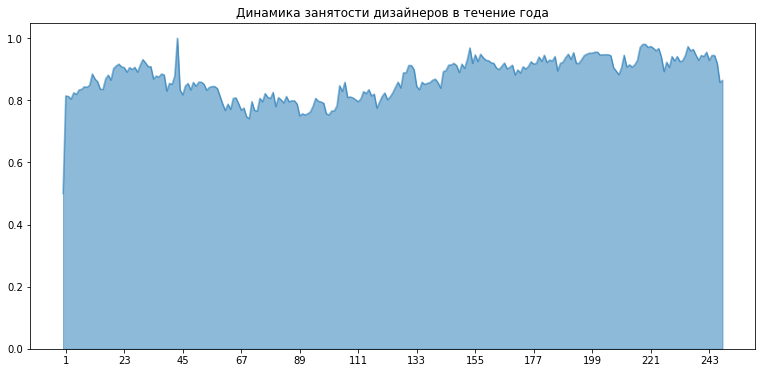

In [32]:
(spec_workload.query("spec == 'дизайнер'").reset_index().workload
              .plot(kind='area', 
                    stacked=False, 
                    title='Динамика занятости дизайнеров в течение года', 
                    xticks=range(1, 249, 22)))

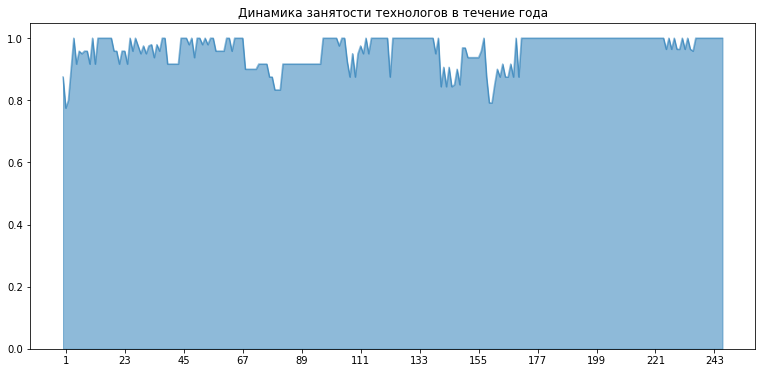

In [33]:
(spec_workload.query("spec == 'технолог'").reset_index().workload
              .plot(kind='area', 
                    stacked=False, 
                    title='Динамика занятости технологов в течение года', 
                    xticks=range(1, 249, 22)))

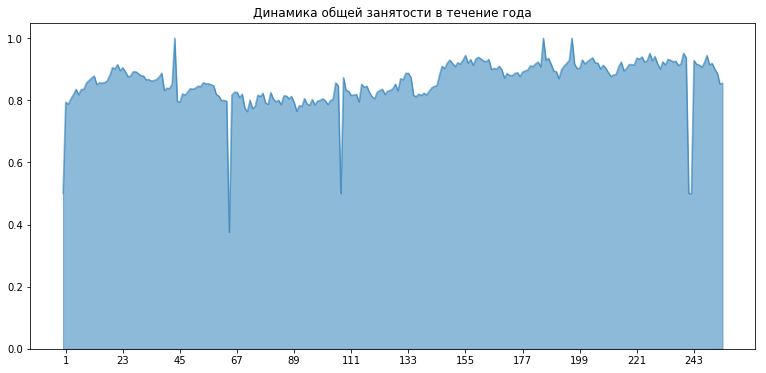

In [34]:
(all_workload.workload.plot(kind='area', 
                                 stacked=False, 
                                 title='Динамика общей занятости в течение года', 
                                 xticks=range(1, 249, 22)))

Несколько резких провалов в графике - это выходные дни, когда некоторые специалисты выходили на несколько часов:

In [35]:
all_workload.sort_values(by='workload').head()

,day,hours_cleared,executive_id,workload
64,2019-04-06,3,1,0.375
0,2019-01-07,4,1,0.500
242,2019-12-15,4,1,0.500
241,2019-12-14,4,1,0.500
107,2019-06-12,16,4,0.500


In [36]:
spec_workload.query("day == ['2019-04-06', '2019-01-07', '2019-12-15']")

,day,spec,hours_cleared,executive_id,workload
0,2019-01-07,дизайнер,4,1,0.500
1043,2019-04-06,фотограф,3,1,0.375
3915,2019-12-15,корректор,4,1,0.500
